In [ ]:
# %%
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
# %%
# LOAD DATA
df = pd.read_csv("Sample - Superstore.csv", encoding='latin1', parse_dates=['Order Date', 'Ship Date'])

# Rename columns for consistency
df.columns = [col.replace(" ", "_") for col in df.columns]
df = df.rename(columns={"Order_Date": "order_date", "Ship_Date": "ship_date"})

print(f"Shape: {df.shape}")
print(f"Date range: {df.order_date.min()} to {df.order_date.max()}")

Shape: (9994, 21)
Date range: 2014-01-03 00:00:00 to 2017-12-30 00:00:00


In [4]:
# %%
# Descriptive stats
numeric_cols = ['Sales', 'Quantity', 'Discount', 'Profit']
df[numeric_cols].describe()

,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000
mean,229.858001,3.789574,0.156203,28.656896
std,623.245101,2.225110,0.206452,234.260108
min,0.444000,1.000000,0.000000,-6599.978000
25%,17.280000,2.000000,0.000000,1.728750
50%,54.490000,3.000000,0.200000,8.666500
75%,209.940000,5.000000,0.200000,29.364000
max,22638.480000,14.000000,0.800000,8399.976000


<h3>Visualisasi Distribusi Profit</h3>

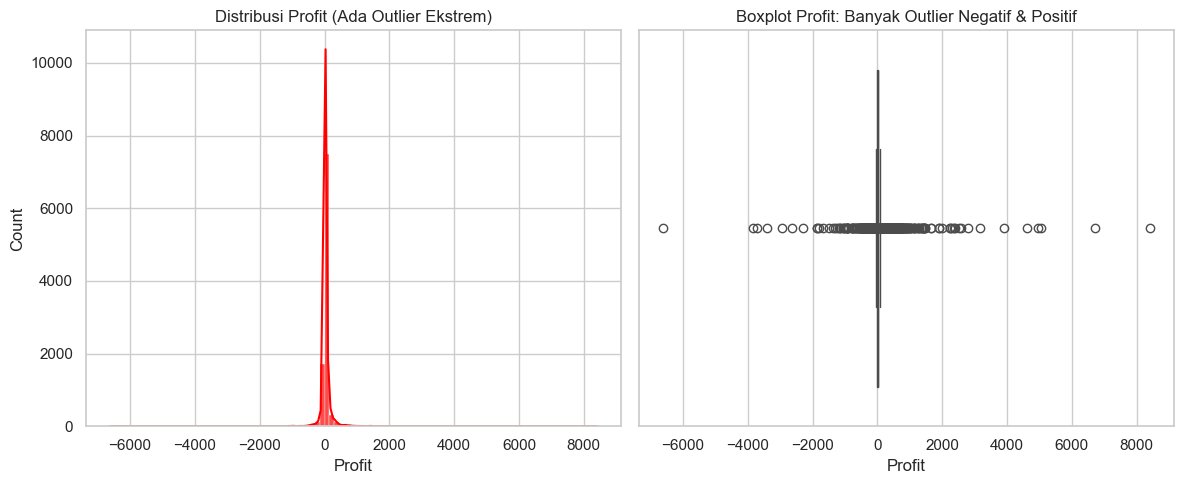

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Profit'], bins=100, kde=True, color='red', alpha=0.7)
plt.title("Distribusi Profit (Ada Outlier Ekstrem)")
plt.xlabel("Profit")

plt.subplot(1, 2, 2)
sns.boxplot(x=df['Profit'])
plt.title("Boxplot Profit: Banyak Outlier Negatif & Positif")

plt.tight_layout()
plt.savefig("plots/profit_distribution.png", dpi=150, bbox_inches='tight')
plt.show()

<h3>Discount vs Profit</h3>

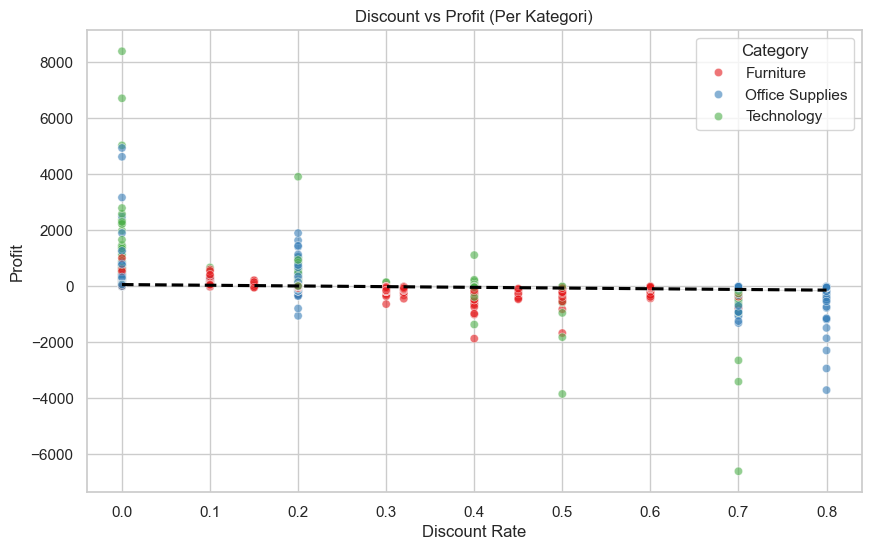

In [8]:
# %%
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Discount', y='Profit', alpha=0.6, hue='Category', palette='Set1')
sns.regplot(data=df, x='Discount', y='Profit', scatter=False, color='black', line_kws={'linestyle':'--'})
plt.title("Discount vs Profit (Per Kategori)")
plt.xlabel("Discount Rate")
plt.ylabel("Profit")
plt.legend(title="Category")
plt.savefig("plots/discount_vs_profit.png", dpi=150, bbox_inches='tight')
plt.show()

<h3>Profit per kategori dan segmen</h3>

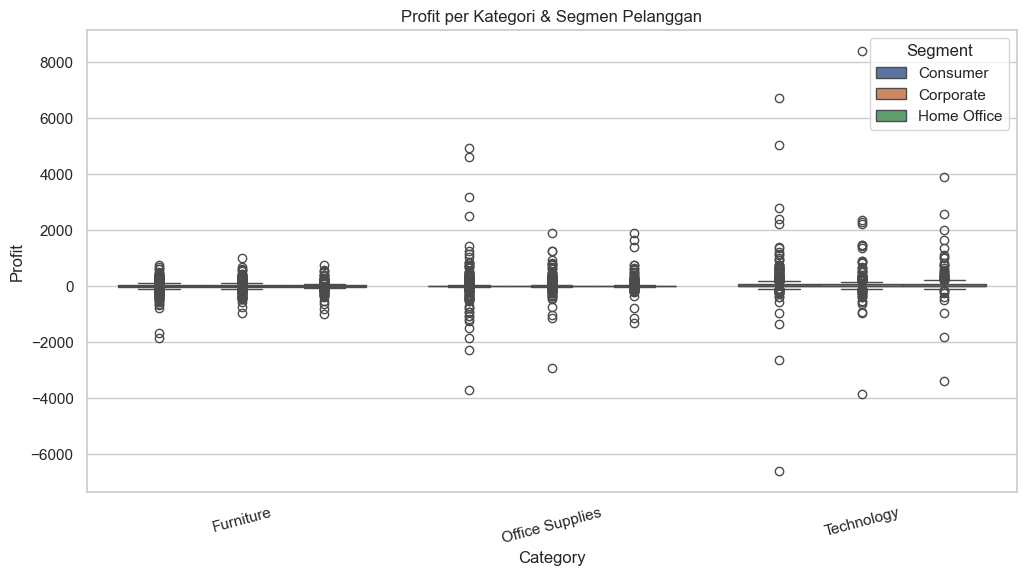

In [9]:
# %%
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Category', y='Profit', hue='Segment')
plt.title("Profit per Kategori & Segmen Pelanggan")
plt.xticks(rotation=15)
plt.ylabel("Profit")
plt.legend(title="Segment")
plt.savefig("plots/profit_by_category_segment.png", dpi=150, bbox_inches='tight')
plt.show()

<h3>Rata-Rata diskon per segmen</h3>

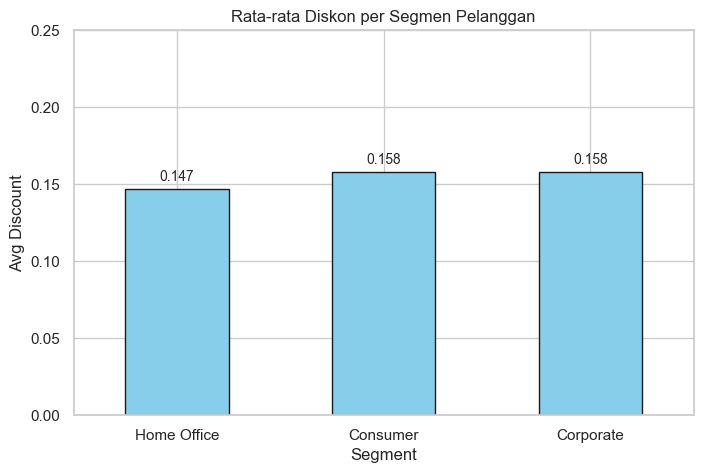

In [ ]:
discount_by_segment = df.groupby('Segment')['Discount'].mean().sort_values()
plt.figure(figsize=(8, 5))
discount_by_segment.plot(kind='bar', color='skyblue', edgecolor='k')
plt.title("Rata-rata Diskon per Segmen Pelanggan")
plt.ylabel("Avg Discount")
plt.xticks(rotation=0)
for i, v in enumerate(discount_by_segment):
    plt.text(i, v + 0.005, f"{v:.3f}", ha='center', fontsize=10)
plt.ylim(0, 0.25)
plt.savefig("plots/discount_by_segment.png", dpi=150, bbox_inches='tight')
plt.show()

<h3>Feature Engineering</h3>

In [11]:
# %%
# Feature engineering
df['month'] = df['order_date'].dt.month
df['year'] = df['order_date'].dt.year
df['day_of_week'] = df['order_date'].dt.dayofweek
df['shipping_duration'] = (df['ship_date'] - df['order_date']).dt.days

# One-hot untuk kategori rendah-kardinalitas
X_cat = pd.get_dummies(df[['Category', 'Sub-Category', 'Region', 'Segment', 'Ship_Mode']], drop_first=True)

# Feature numerik
X_num = df[['Sales', 'Quantity', 'month', 'year', 'day_of_week', 'shipping_duration']]

# Gabung
X = pd.concat([X_num, X_cat], axis=1)
T = df['Discount'].values
Y = df['Profit'].values

print(f"X shape: {X.shape} | T shape: {T.shape} | Y shape: {Y.shape}")

X shape: (9994, 32) | T shape: (9994,) | Y shape: (9994,)


In [49]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

class ContinuousDoubleML:
    def __init__(self, learner_T=None, learner_Y=None, n_folds=5, random_state=42):
        self.learner_T = learner_T or RandomForestRegressor(
            n_estimators=100, random_state=random_state
        )
        self.learner_Y = learner_Y or RandomForestRegressor(
            n_estimators=100, random_state=random_state
        )
        self.n_folds = n_folds
        self.random_state = random_state
        self.effect_ = None
        self.residuals_ = {}

    def fit(self, X, T, Y):
        np.random.seed(self.random_state)
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)

        v_hat_all = np.zeros(X.shape[0])
        epsilon_hat_all = np.zeros(X.shape[0])

        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            T_train, T_test = T[train_idx], T[test_idx]
            Y_train, Y_test = Y[train_idx], Y[test_idx]

            # 1. Estimate T ~ X
            self.learner_T.fit(X_train, T_train)
            v_hat = T_test - self.learner_T.predict(X_test)

            # 2. Estimate Y ~ X
            self.learner_Y.fit(X_train, Y_train)
            epsilon_hat = Y_test - self.learner_Y.predict(X_test)  # ✅ FIXED

            # Simpan residual cross-fitted
            v_hat_all[test_idx] = v_hat
            epsilon_hat_all[test_idx] = epsilon_hat

        # 3. Regresi residual Y terhadap residual T
        ols = LinearRegression().fit(v_hat_all.reshape(-1, 1), epsilon_hat_all)
        self.effect_ = ols.coef_[0]

        self.residuals_ = {"v_hat": v_hat_all, "epsilon_hat": epsilon_hat_all}
        return self.effect_
